In [7]:
import pandas as pd
import sqlite3

df = pd.read_csv("clinical_trial_mock_data.csv")

conn = sqlite3.connect(":memory:")

df.to_sql("trials", conn, index=False, if_exists="replace")

pd.read_sql("SELECT * FROM trials LIMIT 5;", conn)

,Trial_ID,Drug_Name,Indication,Enrollment_Target,Enrolled_Patients,Adverse_Events_Rate,Retention_Rate,FDA_Status,Start_Date,End_Date,Region
0,TRIAL_001,Drug_A0,Bipolar Disorder,802,379,0.19,0.68,Denied,2023-01-01,2023-06-26,Asia
1,TRIAL_002,Drug_B1,Schizophrenia,501,250,0.17,0.95,Approved,2023-01-08,2023-08-29,North America
2,TRIAL_003,Drug_C2,Bipolar Disorder,829,154,0.07,0.97,Pending,2023-01-15,2023-08-16,North America
3,TRIAL_004,Drug_D3,Bipolar Disorder,655,542,0.28,0.64,Pending,2023-01-22,2023-12-20,North America
4,TRIAL_005,Drug_E4,Bipolar Disorder,261,54,0.18,0.65,Approved,2023-01-29,2024-01-18,Asia


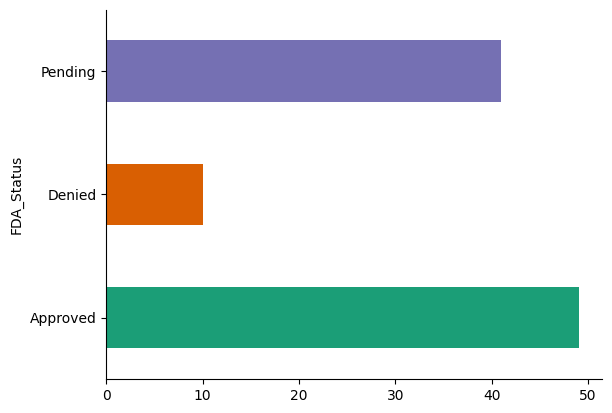

In [4]:
# @title FDA_Status

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('FDA_Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
# Find FDA Apprpvals status
query1 = """
SELECT FDA_Status, COUNT(*) AS count
FROM trials
GROUP BY FDA_Status
ORDER BY count DESC;
"""
pd.read_sql(query1, conn)

,FDA_Status,count
0,Approved,49
1,Pending,41
2,Denied,10


In [9]:
# In different regions, get 'average retention rate',  'enrollment rate',  'total trial numbers'
query2 = """
SELECT Region,
       ROUND(AVG(Retention_Rate), 2) AS Avg_Retention,
       ROUND(AVG(CAST(Enrolled_Patients AS FLOAT) / Enrollment_Target), 2) AS Avg_Progress,
       COUNT(*) AS Trial_Count
FROM trials
GROUP BY Region
ORDER BY Avg_Progress DESC;
"""
pd.read_sql(query2, conn)

,Region,Avg_Retention,Avg_Progress,Trial_Count
0,Asia,0.72,0.57,33
1,North America,0.73,0.55,39
2,Europe,0.75,0.46,28


In [11]:
# find high-risk drugs with rate over 0.25
query3 = """
SELECT Trial_ID, Drug_Name, Indication, Adverse_Events_Rate, Retention_Rate
FROM trials
WHERE Adverse_Events_Rate > 0.25
ORDER BY Adverse_Events_Rate DESC;
"""
pd.read_sql(query3, conn)

,Trial_ID,Drug_Name,Indication,Adverse_Events_Rate,Retention_Rate
0,TRIAL_040,Drug_N39,Bipolar Disorder,0.30,0.96
1,TRIAL_057,Drug_E56,Schizophrenia,0.30,0.67
2,TRIAL_085,Drug_G84,Bipolar Disorder,0.30,0.91
3,TRIAL_042,Drug_P41,Bipolar Disorder,0.29,0.77
4,TRIAL_082,Drug_D81,Schizophrenia,0.29,0.57
5,TRIAL_086,Drug_H85,Bipolar Disorder,0.29,0.62
6,TRIAL_004,Drug_D3,Bipolar Disorder,0.28,0.64
7,TRIAL_071,Drug_S70,Schizophrenia,0.28,0.80
8,TRIAL_097,Drug_S96,Schizophrenia,0.28,0.70
9,TRIAL_007,Drug_G6,Bipolar Disorder,0.27,0.72


In [12]:
# find trials that have higher retention rate, but with a lower progress rate (potential risks)
query4 = """
SELECT Trial_ID, Drug_Name, Retention_Rate,
       Enrolled_Patients, Enrollment_Target,
       ROUND(CAST(Enrolled_Patients AS FLOAT) / Enrollment_Target, 2) AS Progress
FROM trials
WHERE Retention_Rate > 0.85 AND Progress < 0.5;
"""
pd.read_sql(query4, conn)


,Trial_ID,Drug_Name,Retention_Rate,Enrolled_Patients,Enrollment_Target,Progress
0,TRIAL_003,Drug_C2,0.97,154,829,0.19
1,TRIAL_014,Drug_N13,0.86,151,351,0.43
2,TRIAL_035,Drug_I34,0.98,352,938,0.38
3,TRIAL_040,Drug_N39,0.96,176,571,0.31
4,TRIAL_052,Drug_Z51,0.91,54,330,0.16
5,TRIAL_091,Drug_M90,0.90,120,674,0.18
6,TRIAL_093,Drug_O92,0.96,356,842,0.42


In [13]:
df["Start_Date"] = pd.to_datetime(df["Start_Date"])
df["End_Date"] = pd.to_datetime(df["End_Date"])
df["Duration_Days"] = (df["End_Date"] - df["Start_Date"]).dt.days


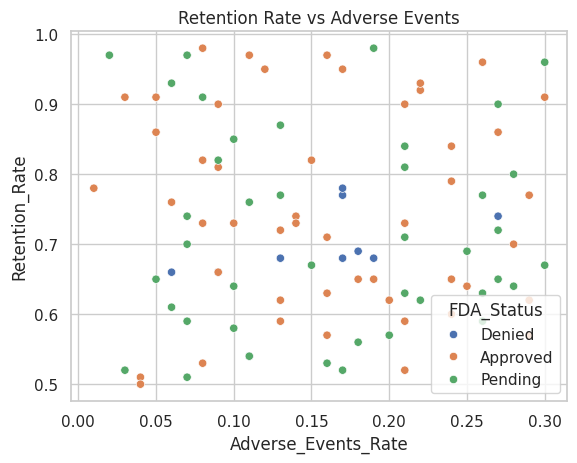

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="Adverse_Events_Rate", y="Retention_Rate", hue="FDA_Status")
plt.title("Retention Rate vs Adverse Events")
plt.show()

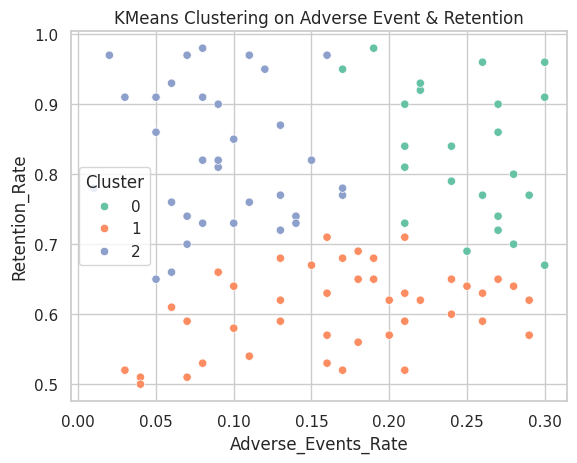

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = df[["Adverse_Events_Rate", "Retention_Rate"]].dropna()
scaler = StandardScaler()
X = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

sns.scatterplot(data=df, x="Adverse_Events_Rate", y="Retention_Rate", hue="Cluster", palette="Set2")
plt.title("KMeans Clustering on Adverse Event & Retention")
plt.show()

In [16]:
region_summary = pd.read_sql(query2, conn)
region_summary.to_csv("region_summary_for_tableau.csv", index=False)

In [19]:
df_trial_level = df[["Trial_ID", "Drug_Name", "Indication", "Adverse_Events_Rate",
                     "Retention_Rate", "FDA_Status", "Region", "Duration_Days"]]
df_trial_level.to_csv("trial_level_tableau.csv", index=False)